In [40]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import cm
import re

ModuleNotFoundError: No module named 'colorspacious'

In [2]:
## I'm going to try out years 981-985 in the model and see the differences between these years and years 711-715
## If there's a significant difference then I think evaluating all the years together might be useful? 

rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir_temp = 'ocean_monthly_z/ts/monthly/5yr/'
filename_temp = 'ocean_monthly_z.071101-071512.thetao.nc'



datadir_phyto = 'ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/'
filename_phyto = 'ocean_cobalt_omip_tracers_month_z.071101-071512.phyc.nc'


temp = xr.open_dataset(rootdir+datadir_temp+filename_temp)
phyto = xr.open_dataset(rootdir+datadir_phyto+filename_phyto)

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [3]:
ds = xr.merge([temp, phyto])

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [4]:
filename_volume = 'ocean_cobalt_omip_tracers_month_z.071101-071512.volcello.nc'
volume = xr.open_dataset(rootdir+datadir_phyto+filename_volume)

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [27]:
df = xr.merge([ds, volume])
df

<xarray.Dataset>
Dimensions:     (nv: 2, time: 60, xh: 720, yh: 576, z_i: 36, z_l: 35)
Coordinates:
  * time        (time) object 0711-01-16 12:00:00 ... 0715-12-16 12:00:00
  * xh          (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh          (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l         (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * nv          (nv) float64 1.0 2.0
  * z_i         (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
Data variables:
    phyc        (time, z_l, yh, xh) float32 dask.array<shape=(60, 35, 576, 720), chunksize=(49, 35, 576, 720)>
    thetao      (time, z_l, yh, xh) float32 dask.array<shape=(60, 35, 576, 720), chunksize=(49, 35, 576, 720)>
    average_DT  (time) timedelta64[ns] ...
    average_T1  (time) object ...
    average_T2  (time) object ...
    time_bnds   (time, nv) object ...
    volcello    (time, z_l, yh, xh) float32 ...

In [7]:
pV = df.volcello*df.phyc
pV.name = 'pV'
df = xr.merge([df,pV])

In [8]:
df = df.set_coords('thetao')
theta_bins = np.arange(-2,30,2) 

In [8]:
## Dummy data array that the lad Graeme made

pV_in_theta = df.pV.isel(time=0,yh=range(0,576),z_l = 0).groupby_bins('thetao',theta_bins)
p_vmean = pV_in_theta.sum(xr.ALL_DIMS)
p_vmean.values

array([2.4787871e+11, 3.0966317e+11, 2.0922397e+11, 1.7597178e+11,
       1.7413272e+11, 1.7746148e+11, 1.8660701e+11, 1.9054259e+11,
       2.1742428e+11, 1.9266558e+11, 1.3965995e+11, 1.3830695e+11,
       2.0044613e+11, 3.9632903e+11, 3.3385329e+11], dtype=float32)

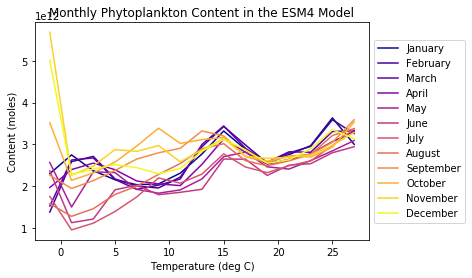

In [26]:
## WOO JESUS, THIS WAS SO ANNOYING TO FIGURE OUT. 
## Anyway, here's what the amount of moles of phytoplankton look like at different temperatures in the ocean! 

labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
colors = cm.get_cmap('plasma',12).colors 

for t in range(12):
    pV_in_theta = df.pV.isel(time=t,yh=range(0,576)).groupby_bins('thetao',theta_bins)
 
    p_vmean = pV_in_theta.sum(xr.ALL_DIMS)
       

    p_vmean.plot(label=labels[t], color=colors[t,:])
    
plt.title('Monthly Phytoplankton Content in the ESM4 Model')
plt.xlabel('Temperature (deg C)')
plt.ylabel('Content (moles)')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) 


In [11]:
## Ugh, $%@& let's try this again!


## Okie dokie so the graph above only shows monthly phytoplankton content over the course of ONE year
## Let's take the average of each month in the five year period and see how it looks!
## We're going to try out Graeme's new method!



#We're gonna layout the exact directories and file names to create the path for both the biogeochemical and physical variables

rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'

datadir_bgc = 'ocean_cobalt_omip_tracers_month_z/av/monthly_5yr/'
filename_bgc = 'ocean_cobalt_omip_tracers_month_z.0711-0715.*.nc'


datadir_phys = 'ocean_monthly_z/av/monthly_5yr/'
filename_phys = 'ocean_monthly_z.0711-0715.*.nc'


In [19]:
## Now we're going to open the datasets using the paths that we created above!

# Biogeochemical dataset 

bgc_variables = xr.open_mfdataset(rootdir+datadir_bgc+filename_bgc)

#Physical dataset

phys_variables = xr.open_mfdataset(rootdir+datadir_phys+filename_phys)


In [30]:
ds = xr.merge([phys_variables.thetao, bgc_variables.phyc, bgc_variables.volcello]) 
ds.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:   (time: 12, xh: 720, yh: 576, z_l: 35)
Coordinates:
  * xh        (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh        (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l       (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time      (time) object 0715-01-16 12:00:00 ... 0715-12-16 12:00:00
Data variables:
    thetao    (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>
    phyc      (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>
    volcello  (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>>

In [44]:
# Phytoplankton x volume variable 

pV_av = ds.phyc* ds.volcello
pV_av.name = 'pV_av'
ds = xr.merge([ds,pV_av])
ds.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:   (time: 12, xh: 720, yh: 576, z_l: 35)
Coordinates:
  * xh        (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh        (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l       (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time      (time) object 0715-01-16 12:00:00 ... 0715-12-16 12:00:00
    thetao    (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>
Data variables:
    phyc      (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>
    volcello  (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>
    pV_av     (time, z_l, yh, xh) float32 dask.array<shape=(12, 35, 576, 720), chunksize=(1, 35, 576, 720)>>

In [34]:
ds = ds.set_coords('thetao')
theta_bins = np.arange(-2,30,2) 

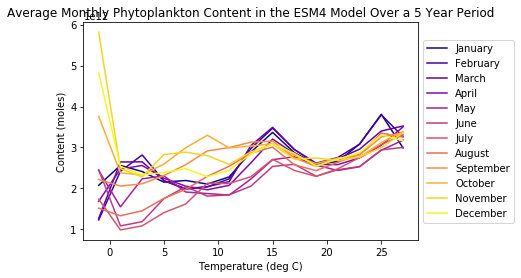

In [43]:
labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
colors = cm.get_cmap('plasma',12).colors 

for t in range(12):
    pV_in_theta = ds.pV_av.isel(time=t,yh=range(0,576)).groupby_bins('thetao',theta_bins)
 
    p_vmean = pV_in_theta.sum(xr.ALL_DIMS)
       

    p_vmean.plot(label=labels[t], color=colors[t,:])
    
plt.title('Average Monthly Phytoplankton Content in the ESM4 Model Over a 5 Year Period')
plt.xlabel('Temperature (deg C)')
plt.ylabel('Content (moles)')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

In [41]:
## Alrighty let's check out phytoplankton content (aka moles) over seasons
## Why? Well in the graph above there seems to be a lot of seasonality going on so I(read: we as in Graeme and I)..
## ..decided to break it down into a hopefully more decipherable graph
## We also thought it would be interesting to see how phytoplankton content changes over seasons instead of monthly

labels = ['December, January February', "March, April, May", "June, July, August", "September, October, November"]
colors = cm.get_cmap('viridis',12).colors 

DJF = np.arange(0,4,1)
MAM = [3,4,5]
JJA = [6,7,8]
SON = [9,10,11] 

for t in (DJF, MAM, JJA, SON):

    pV_in_theta = ds.pV_av.isel(time=t,yh=range(0,576)).groupby_bins('thetao',theta_bins)
 
    p_vmean = pV_in_theta.sum(xr.ALL_DIMS)

    p_vmean.plot(label=labels[t], color=colors[t,:])

plt.title('Average Seasonal Phytoplankton Concentrations in ESM4 Model Over a 5 Year Period')
plt.legend()
plt.xlabel('Temperature (deg C)')
plt.ylabel('Phytoplankton Content (moles)')
plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) 

TypeError: list indices must be integers or slices, not list